In [1]:
import numpy as np
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
textsize = 'x-large'
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': textsize,
         'axes.titlesize': textsize,
         'xtick.labelsize': textsize,
         'ytick.labelsize': textsize,
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import os

import h5py
import corner

%load_ext autoreload
%autoreload 2
import plotter
import emulator

In [7]:
all_params = ['Omega_m', 'Omega_b', 'sigma_8', 'h', 'n_s', 'N_eff', 'w', 'M_sat', 'alpha', 'M_cut', 'sigma_logM', 'v_bc', 'v_bs', 'c_vir', 'f', 'f_env', 'delta_env', 'sigma_env']

In [12]:
cosmo_params = ['Omega_m', 'Omega_b', 'sigma_8', 'h', 'n_s', 'N_eff', 'w']
hod_params = ['M_sat', 'alpha', 'M_cut', 'sigma_logM', 'v_bc', 'v_bs', 'c_vir', 'f']
ab_params = ['f_env', 'delta_env', 'sigma_env']

In [2]:
param_labels = {'Omega_m': '$\Omega_m$', 
                'Omega_b': '$\Omega_b$', 
                'sigma_8': '$\sigma_8$', 
                'h': '$h$', 
                'n_s': '$n_s$',
                'N_eff': '$N_{eff}$', 
                'w': '$w$', 
                'M_sat': '$M_{sat}$', 
                'alpha': '$\alpha$', 
                'M_cut': '$M_{cut}$', 
                'sigma_logM': '$\sigma_{logM}$', 
                'v_bc': '$v_{bc}$', 
                'v_bs': '$v_{bs}$', 
                'c_vir': '$c_{vir}$', 
                'f': '$f$', 
                'f_env': '$f_{env}$', 
                'delta_env': '$\delta_{env}$', 
                'sigma_env': '$\sigma_{env}$'}

In [3]:
cosmo, hod = 3, 3
statistic = 'wp'
traintag = '_nonolap'
testtag = '_mean_test0'
errtag = '_100hod_test0'
kernel_name = 'M32ExpConst2'
nhod = 100
tag = '_log_kM32ExpConst2_{}hod'.format(nhod)

gptag = traintag + errtag + tag
res_dir = '../../clust/results_{}/'.format(statistic)
gperr = np.loadtxt(res_dir+"{}_error{}.dat".format(statistic, errtag))
training_dir = '{}training_{}{}/'.format(res_dir, statistic, traintag)
testing_dir = '{}testing_{}{}/'.format(res_dir, statistic, testtag)
hyperparams = "../training_results/{}_training_results{}.dat".format(statistic, gptag)

emu = emulator.Emulator(statistic, training_dir, gperr=gperr, hyperparams=hyperparams, nhod=nhod, kernel_name=kernel_name)
emu.build()

george version: 0.3.1
Loading training data
Nparams: 18
Rebuilding emulators


In [4]:
def check_chains(chaintag): 
    chain_fn = f'../chains/chains_{chaintag}.h5'
    if os.path.exists(chain_fn):
        fw = h5py.File(chain_fn, 'r')
        chain_dset = fw['chain']
        print(f"{chaintag}: {chain_dset}")
        fw.close()
    else:
        print(f"chain {chain_fn} doesn't exist!")

In [5]:
def plot_chains(chaintag, show_walkers=False, show_corner=True, show_params=None, figure=None, nsteps=None, color='blue'): 
    #chaintag = 'wp_c3h3_Msat_fenv_xlong_diag'
    chain_fn = f'../chains/chains_{chaintag}.h5'
    fw = h5py.File(chain_fn, 'r')

    chain_dset = fw['chain']
    print(chain_dset)
    chain = np.array(chain_dset)
    lnprob_dset = fw['lnprob']
    param_names = fw.attrs['param_names']
    true_values = fw.attrs['true_values']
    if nsteps:
        chain = chain[:,:nsteps,:]
    nwalkers, nchain, ndim = chain.shape
    fw.close()
    
    if show_params:    
        idxs = []
        for sp in show_params:
            idxs.append(np.where(param_names == sp))
        idxs = np.array(idxs).flatten()
        chain = chain[:,:,idxs]
        param_names = show_params
        true_values = true_values[idxs]

    if show_walkers:
        for k in range(ndim):
            plt.figure()
            pname = param_names[k]
            for j in range(nwalkers):
                plt.title(pname)
                plt.plot(chain[j,:,k], alpha=1)
                low, high = emu.get_param_bounds(pname)
                plt.axhline(low, ls=':', color='k')
                plt.axhline(high, ls=':', color='k')
                plt.axhline(true_values[k], ls='-', lw=2, color='k')
        plt.xlabel('step')

        plt.figure()
        for j in range(nwalkers):
            plt.plot(lnprob_dset[j,:], alpha=1)
        plt.ylabel('lnprob')
        plt.xlabel('step')

    if show_corner:
        labels = [param_labels[pn] for pn in param_names]
        ranges = [emu.get_param_bounds(pn) for pn in param_names]
        fig = corner.corner(chain.reshape(-1, chain.shape[-1]), labels=labels, range=ranges,
                            truths=true_values, fig=figure, color=color, truth_color='black', 
                            hist_kwargs={'density': True}, show_titles=True)
        return fig

Plots for presentation at aemulus telecon 2020-06-25

<HDF5 dataset "chain": shape (250, 32200, 7), type "<f4">
<HDF5 dataset "chain": shape (250, 6500, 7), type "<f4">
<HDF5 dataset "chain": shape (250, 12400, 7), type "<f4">


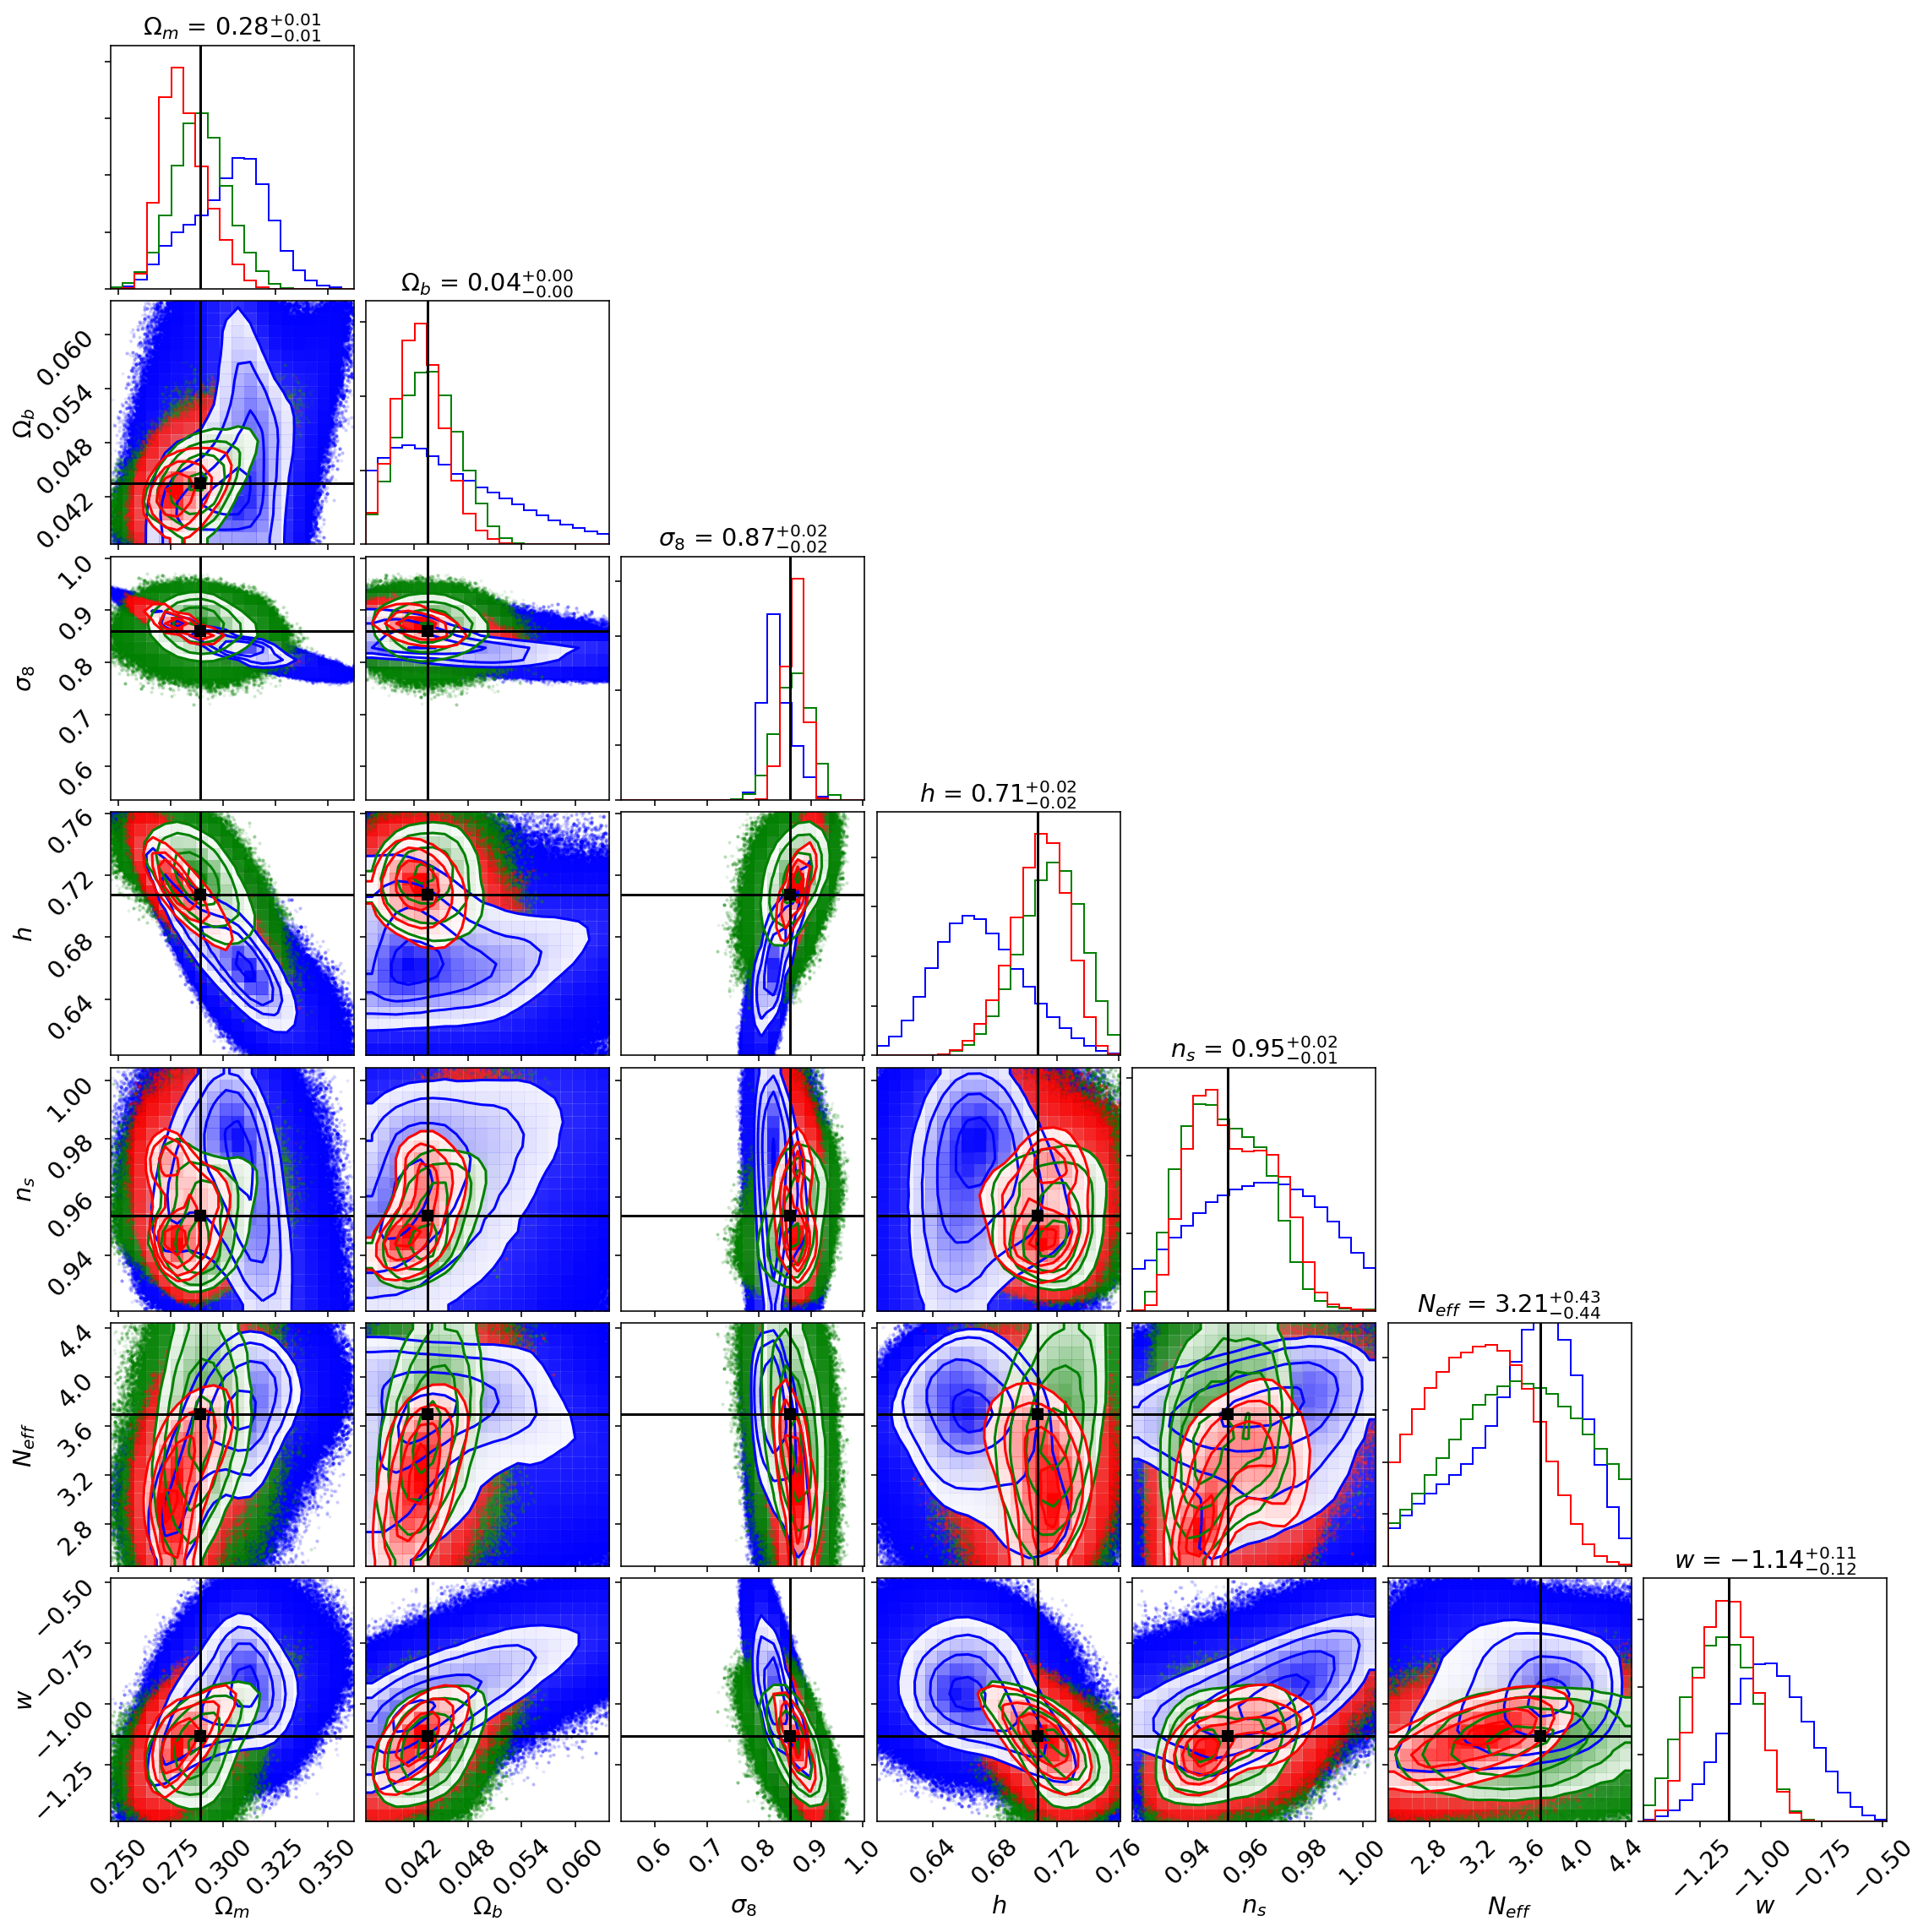

In [8]:
nsteps=None
show_params = ['Omega_m', 'Omega_b', 'sigma_8', 'h', 'n_s', 'N_eff', 'w']
figure = plot_chains('wp_c3h3_allcosmo_covperf_nw250', show_params=show_params, nsteps=nsteps, color='blue')
plt.close()
figure = plot_chains('upf_c3h3_allcosmo_covperf_nw250', figure=figure, show_params=show_params, nsteps=nsteps, color='green')
plt.close()
plot_chains('wp_upf_c3h3_allcosmo_covperf_nw250', figure=figure, show_params=show_params, nsteps=nsteps, color='red')

<HDF5 dataset "chain": shape (250, 46000, 18), type "<f4">
<HDF5 dataset "chain": shape (250, 24700, 18), type "<f4">
<HDF5 dataset "chain": shape (250, 13300, 18), type "<f4">


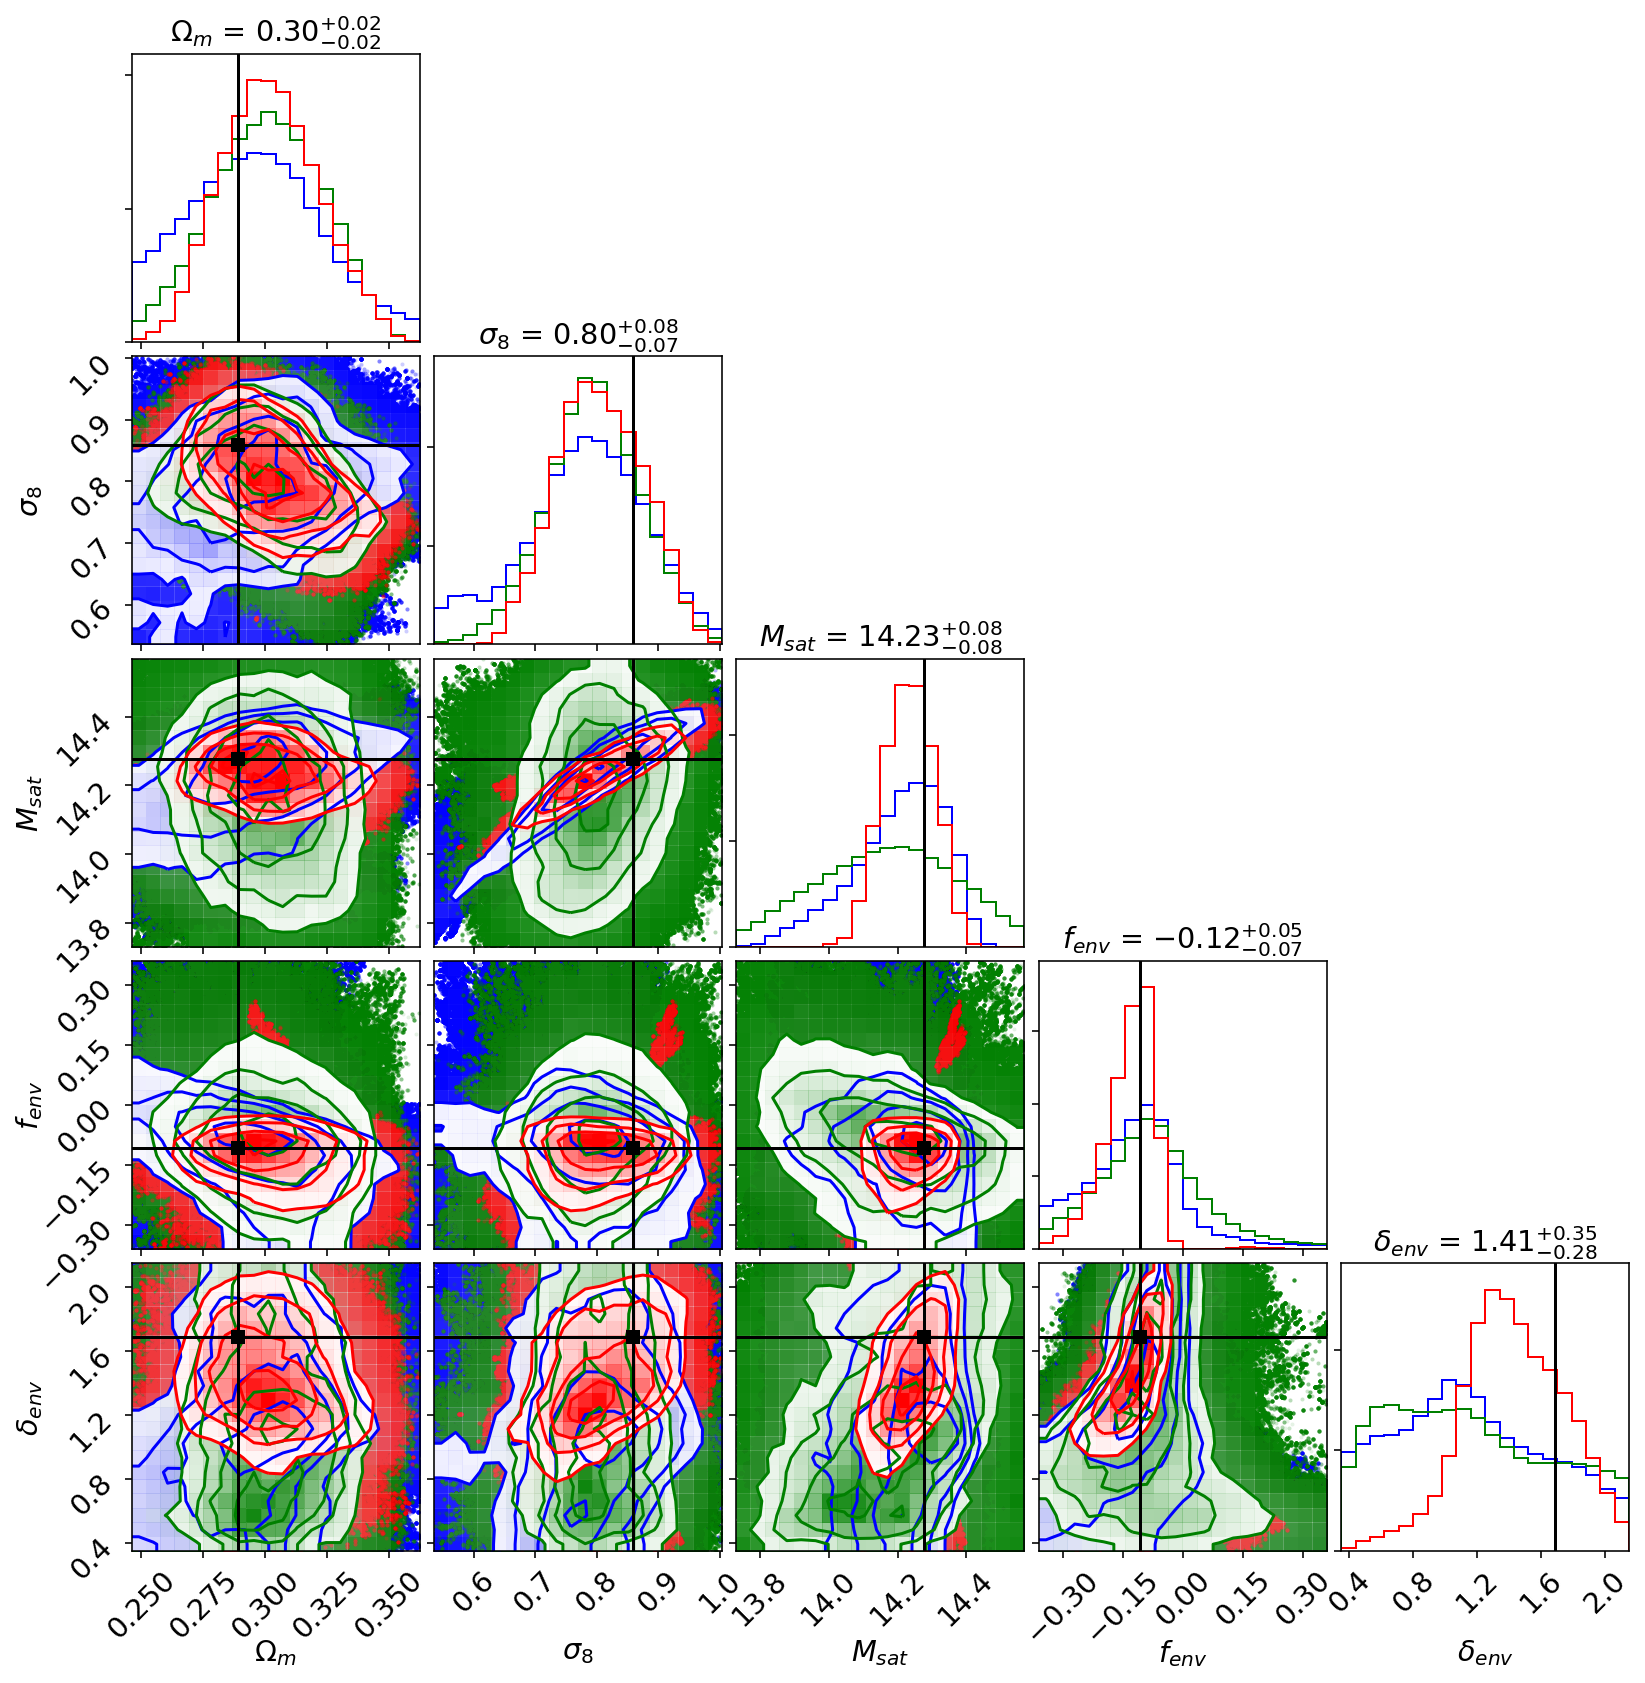

In [7]:
nsteps=None
show_params = ['Omega_m', 'sigma_8', 'M_sat', 'f_env', 'delta_env']
figure = plot_chains('wp_c3h3_all_covperf_nw250', show_params=show_params, nsteps=nsteps, color='blue')
plt.close()
figure = plot_chains('upf_c3h3_all_covperf_nw250', figure=figure, show_params=show_params, nsteps=nsteps, color='green')
plt.close()
plot_chains('wp_upf_c3h3_all_covperf_nw250', figure=figure, show_params=show_params, nsteps=nsteps, color='red')

<HDF5 dataset "chain": shape (250, 49800, 18), type "<f4">
<HDF5 dataset "chain": shape (250, 24700, 18), type "<f4">
<HDF5 dataset "chain": shape (250, 13300, 18), type "<f4">


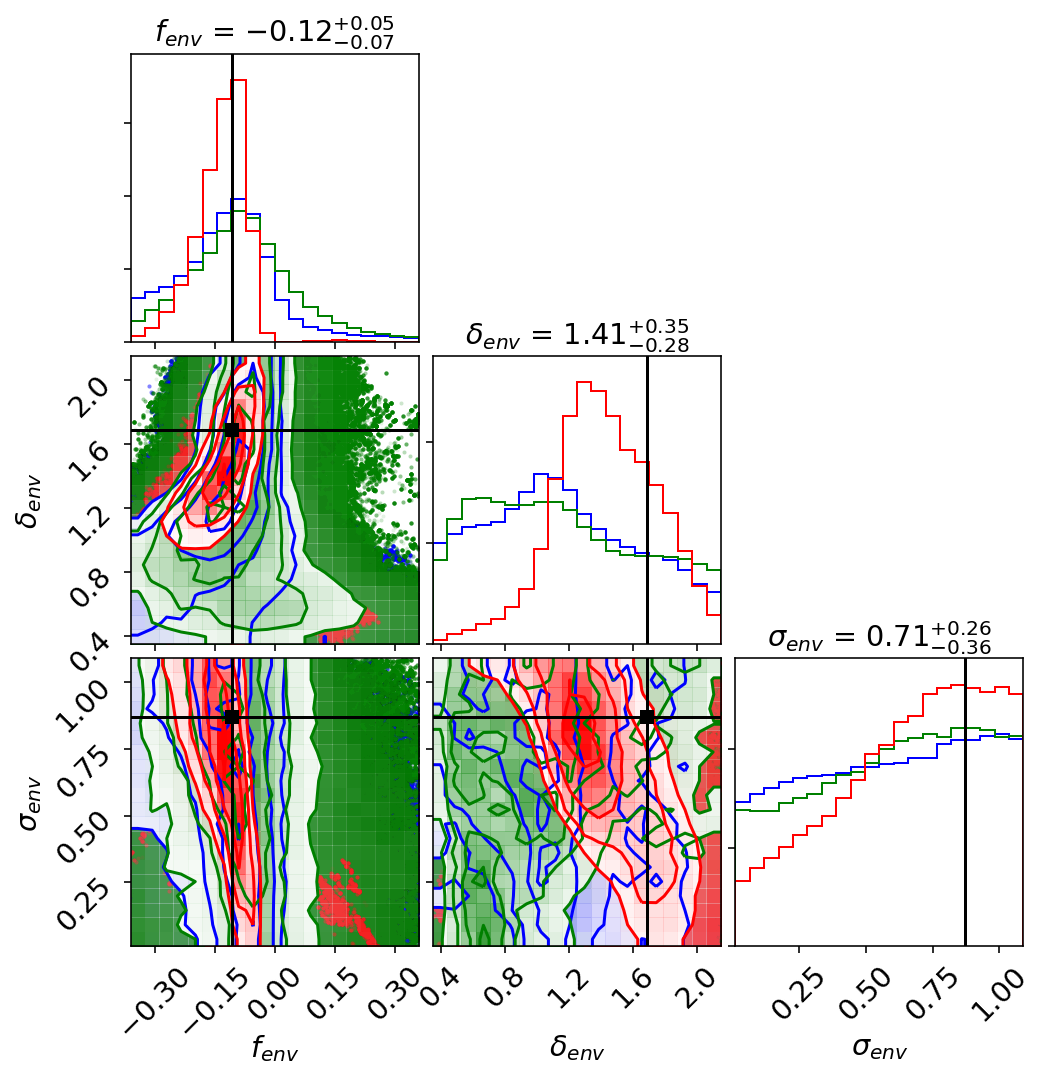

In [13]:
nsteps=None
show_params = ab_params
figure = plot_chains('wp_c3h3_all_covperf_nw250', show_params=show_params, nsteps=nsteps, color='blue')
plt.close()
figure = plot_chains('upf_c3h3_all_covperf_nw250', figure=figure, show_params=show_params, nsteps=nsteps, color='green')
plt.close()
plot_chains('wp_upf_c3h3_all_covperf_nw250', figure=figure, show_params=show_params, nsteps=nsteps, color='red')

<HDF5 dataset "chain": shape (250, 49800, 18), type "<f4">
<HDF5 dataset "chain": shape (250, 24700, 18), type "<f4">
<HDF5 dataset "chain": shape (250, 13300, 18), type "<f4">


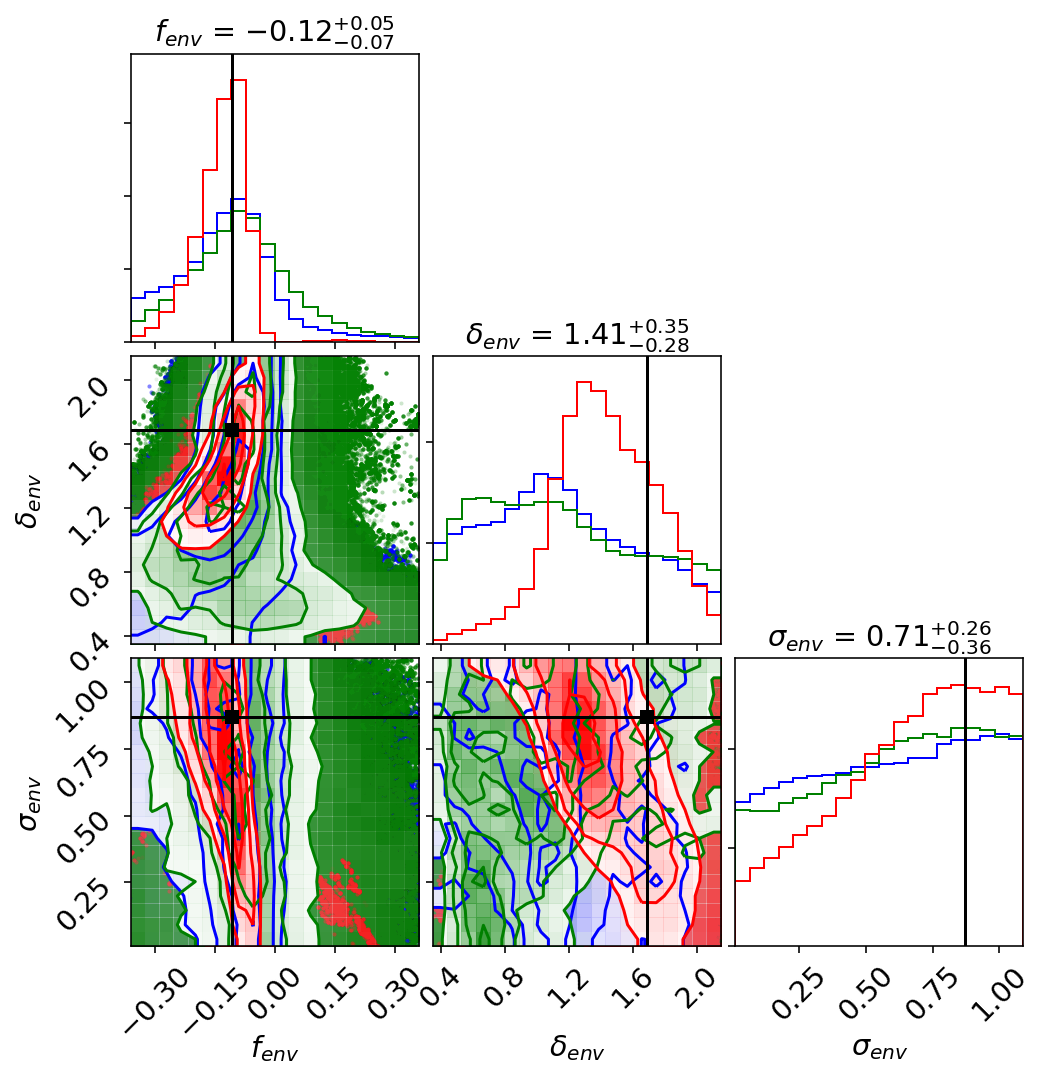

In [11]:
nsteps=None
show_params = ab_params
figure = plot_chains('wp_c3h3_all_covperf_nw250', show_params=show_params, nsteps=nsteps, color='blue')
plt.close()
figure = plot_chains('upf_c3h3_all_covperf_nw250', figure=figure, show_params=show_params, nsteps=nsteps, color='green')
plt.close()
plot_chains('wp_upf_c3h3_all_covperf_nw250', figure=figure, show_params=show_params, nsteps=nsteps, color='red')

<HDF5 dataset "chain": shape (250, 32200, 7), type "<f4">
<HDF5 dataset "chain": shape (250, 12400, 7), type "<f4">


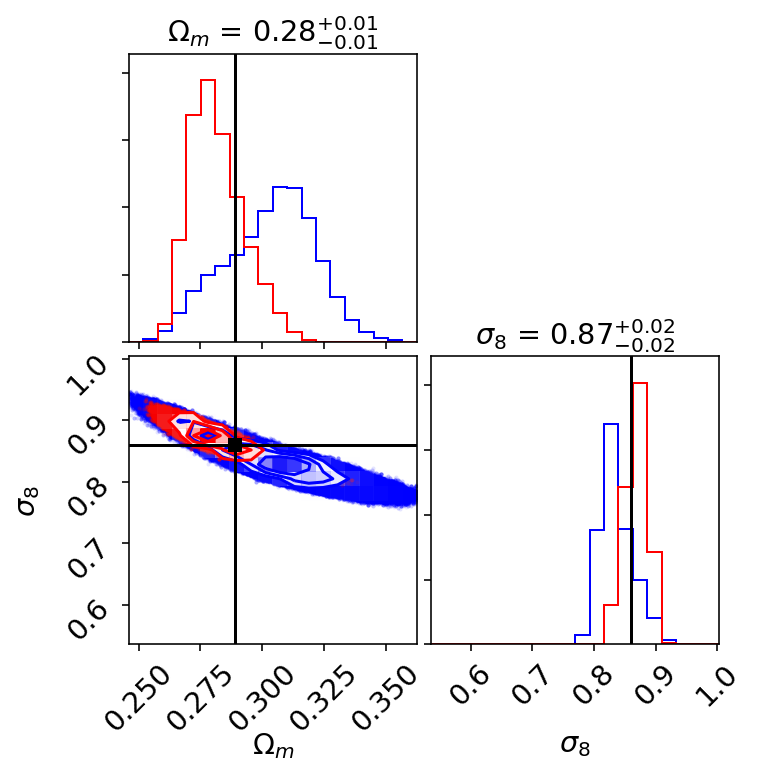

In [6]:
nsteps=None
show_params = ['Omega_m', 'sigma_8']
figure = plot_chains('wp_c3h3_allcosmo_covperf_nw250', show_params=show_params, nsteps=nsteps, color='blue')
plt.close()
#figure = plot_chains('upf_c3h3_allcosmo_covperf_nw250', figure=figure, show_params=show_params, nsteps=nsteps, color='green')
#plt.close()
plot_chains('wp_upf_c3h3_allcosmo_covperf_nw250', figure=figure, show_params=show_params, nsteps=nsteps, color='red')